In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
import numpy as np
import cv2
import os
import h5py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
from tensorflow.keras import mixed_precision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/New.zip"
extract_dir = "/content/New"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

os.listdir(extract_dir)

In [ ]:
# Constants (define these at the top)
IMAGE_SIZE = (256, 256)
DATASET_DIR = "/content/New/New" 


In [3]:
def load_mat_files(dataset_dir):
    images, masks = [], []
    files = sorted(os.listdir(dataset_dir))
    
    for file in files:
        if file.endswith(".mat"):
            file_path = os.path.join(dataset_dir, file)
            with h5py.File(file_path, 'r') as data:
                try:
                    img = np.array(data['cjdata']['image'], dtype=np.float32)
                    mask = np.array(data['cjdata']['tumorMask'], dtype=np.uint8)
                    
                    # Convert to 8-bit for CLAHE
                    img_8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
                    
                    # Apply CLAHE enhancement
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                    img_clahe = clahe.apply(img_8bit)
                    
                    # Convert back to float and normalize
                    img = img_clahe.astype(np.float32) / 255.0
                    
                    # Resize as before
                    img = cv2.resize(img, IMAGE_SIZE)
                    mask = cv2.resize(mask, IMAGE_SIZE)
                    mask = (mask > 0).astype(np.uint8)  # Ensure binary mask
                    
                    images.append(img[..., np.newaxis])  # Add channel dimension
                    masks.append(mask[..., np.newaxis])
                except KeyError as e:
                    print(f"Skipping {file}: KeyError - {e}")
    return np.array(images), np.array(masks)


In [4]:
# Data Augmentation function
def augment_data(images, masks):
    augmented_images = []
    augmented_masks = []
    
    for img, mask in zip(images, masks):
        # Original
        augmented_images.append(img)
        augmented_masks.append(mask)
      
        # Rotation 90 degrees
        rot_img = np.rot90(img, k=1, axes=(0, 1))
        rot_mask = np.rot90(mask, k=1, axes=(0, 1))
        augmented_images.append(rot_img)
        augmented_masks.append(rot_mask)
        
        # Brightness variation (random)
        brightness = np.random.uniform(0.8, 1.2)
        bright_img = np.clip(img * brightness, 0, 1)
        augmented_images.append(bright_img)
        augmented_masks.append(mask)

    return np.array(augmented_images), np.array(augmented_masks)

In [ ]:

def mUnet_model(input_shape=(256, 256, 1)):
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = input_shape
    
    # Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))  # Fixed this line
    s = inputs

    # Rest of the model remains the same...

    #Contraction path
    c1 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = layers.Dropout(0.2)(c1)
    c1 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)

    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.2)(c2)
    c2 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)

    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(1200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(1200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


    u6 = layers.Conv2DTranspose(600, (2, 2), strides=(2, 2), padding='same')(c5)
    m1 = layers.MaxPooling2D((8, 8))(c1)
    l1 = layers.concatenate([u6, m1])
    u6 = layers.concatenate([l1, c4])
    c6 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)


    u7 = layers.Conv2DTranspose(300, (2, 2), strides=(2, 2), padding='same')(c6)
    m2 = layers.MaxPooling2D((4, 4))(c1)
    l2 = layers.concatenate([u7, m2])
    u7 = layers.concatenate([l2, c3])
    c7 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(150, (2, 2), strides=(2, 2), padding='same')(c7)
    m3 = layers.MaxPooling2D((2, 2))(c1)
    l3 = layers.concatenate([u8, m3])
    u8 = layers.concatenate([l3, c2])
    c8 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.2)(c8)
    c8 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)


    u9 = layers.Conv2DTranspose(75, (2, 2), strides=(2, 2), padding='same')(c8)
    l4 = layers.concatenate([u9, c1])
    u9 = layers.concatenate([l4, c1], axis=3)
    c9 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.2)(c9)
    c9 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs=[inputs], outputs=[outputs])


In [6]:
# Custom Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

# Combined loss function
def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)



In [7]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # Convert y_true to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Ensure y_pred is float32

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [8]:
import tensorflow as tf

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # Convert y_true to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Ensure y_pred is float32

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    return (intersection + smooth) / (union + smooth)


In [9]:
# Load and process data
print("Loading dataset...")
images, masks = load_mat_files(DATASET_DIR)
print(f"Original dataset: {len(images)} images, {len(masks)} masks")

# Augment training data
print("Augmenting data...")
augmented_images, augmented_masks = augment_data(images, masks)
print(f"Augmented dataset: {len(augmented_images)} images, {len(augmented_masks)} masks")

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(augmented_images, augmented_masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Loading dataset...
Original dataset: 3064 images, 3064 masks
Augmenting data...
Augmented dataset: 9192 images, 9192 masks
Train: 6434, Validation: 1838, Test: 920


In [10]:
# Create mUnet model
model = mUnet_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=bce_dice_loss,
    metrics=['accuracy', dice_coefficient, iou_score]
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_dice_coefficient',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_dice_coefficient',
    mode='max',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "best_brain_tumor_model.keras",
    monitor='val_dice_coefficient',
    mode='max',
    save_best_only=True,
    verbose=1
)

# TensorBoard callback for visualization
tensorboard_callback = callbacks.TensorBoard(
    log_dir="./logs",
    histogram_freq=1,
    update_freq='epoch'
)

# Train model
print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=24,
    callbacks=[early_stopping, lr_scheduler, checkpoint, tensorboard_callback]
)

# Save final model
model.save("brain_tumor_unet_final.keras")

Training model...
Epoch 1/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9556 - dice_coefficient: 0.0824 - iou_score: 0.0449 - loss: 1.0678   
Epoch 1: val_dice_coefficient improved from -inf to 0.23378, saving model to best_brain_tumor_model.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.9557 - dice_coefficient: 0.0827 - iou_score: 0.0451 - loss: 1.0673 - val_accuracy: 0.9462 - val_dice_coefficient: 0.2338 - val_iou_score: 0.1326 - val_loss: 0.9136 - learning_rate: 1.0000e-04
Epoch 2/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.9819 - dice_coefficient: 0.3961 - iou_score: 0.2501 - loss: 0.6820
Epoch 2: val_dice_coefficient improved from 0.23378 to 0.37878, saving model to best_brain_tumor_model.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.9819 - dice_coefficient: 0.3963 - iou_score: 0.2503 - loss: 0.6818 - val_accuracy: 0.9695 - val_dice_coefficient: 0.3788 - val_iou_score: 0.2343 - val_loss: 0.7046 - learning_rate: 1.0000e-04

Plotting training history...


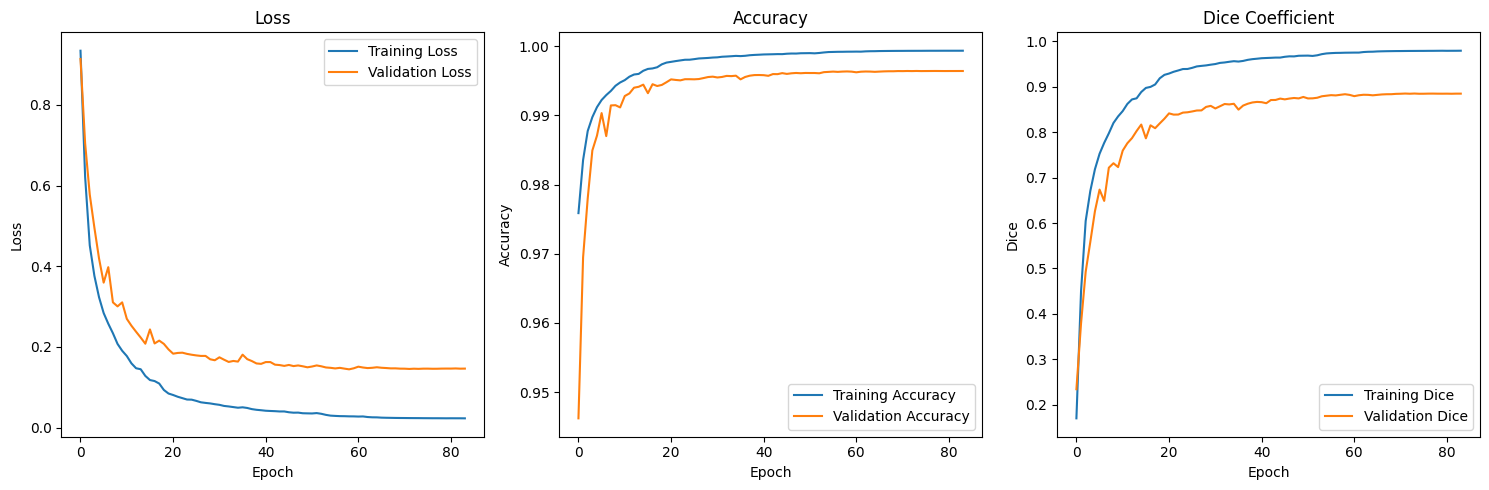

In [11]:
# Visualize training history
def plot_training_history(history):
    # Plot loss
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Dice coefficient
    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_coefficient'], label='Training Dice')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

print("Plotting training history...")
plot_training_history(history)

In [12]:
# Model evaluation
print("Evaluating model...")
evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")
print(f"Test Dice Coefficient: {evaluation[2]}")
print(f"Test IoU Score: {evaluation[3]}")


Evaluating model...
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 309ms/step - accuracy: 0.9965 - dice_coefficient: 0.9006 - iou_score: 0.8204 - loss: 0.1275
Test Loss: 0.1360333114862442
Test Accuracy: 0.9963012933731079
Test Dice Coefficient: 0.8945346474647522
Test IoU Score: 0.8106086850166321


In [13]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)
y_test_bin = (y_test > 0.5).astype(np.uint8)


29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step


In [14]:
# Calculate metrics
dice_score = np.mean([dice_coefficient(y_true, y_pred) for y_true, y_pred in zip(y_test_bin, y_pred_bin)])
iou = np.mean([iou_score(y_true, y_pred) for y_true, y_pred in zip(y_test_bin, y_pred_bin)])

print(f"Dice Score: {dice_score}")
print(f"IoU Score: {iou}")

Dice Score: 0.8719923496246338
IoU Score: 0.8114438056945801


In [15]:
# Confusion matrix
flat_y_test = y_test_bin.flatten()
flat_y_pred = y_pred_bin.flatten()
cm = confusion_matrix(flat_y_test, flat_y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")

Confusion Matrix:
[[59126771    66040]
 [  156965   943344]]
Accuracy: 0.9963
Sensitivity (Recall): 0.8573
Specificity: 0.9989
Precision: 0.9346


Visualizing random predictions...


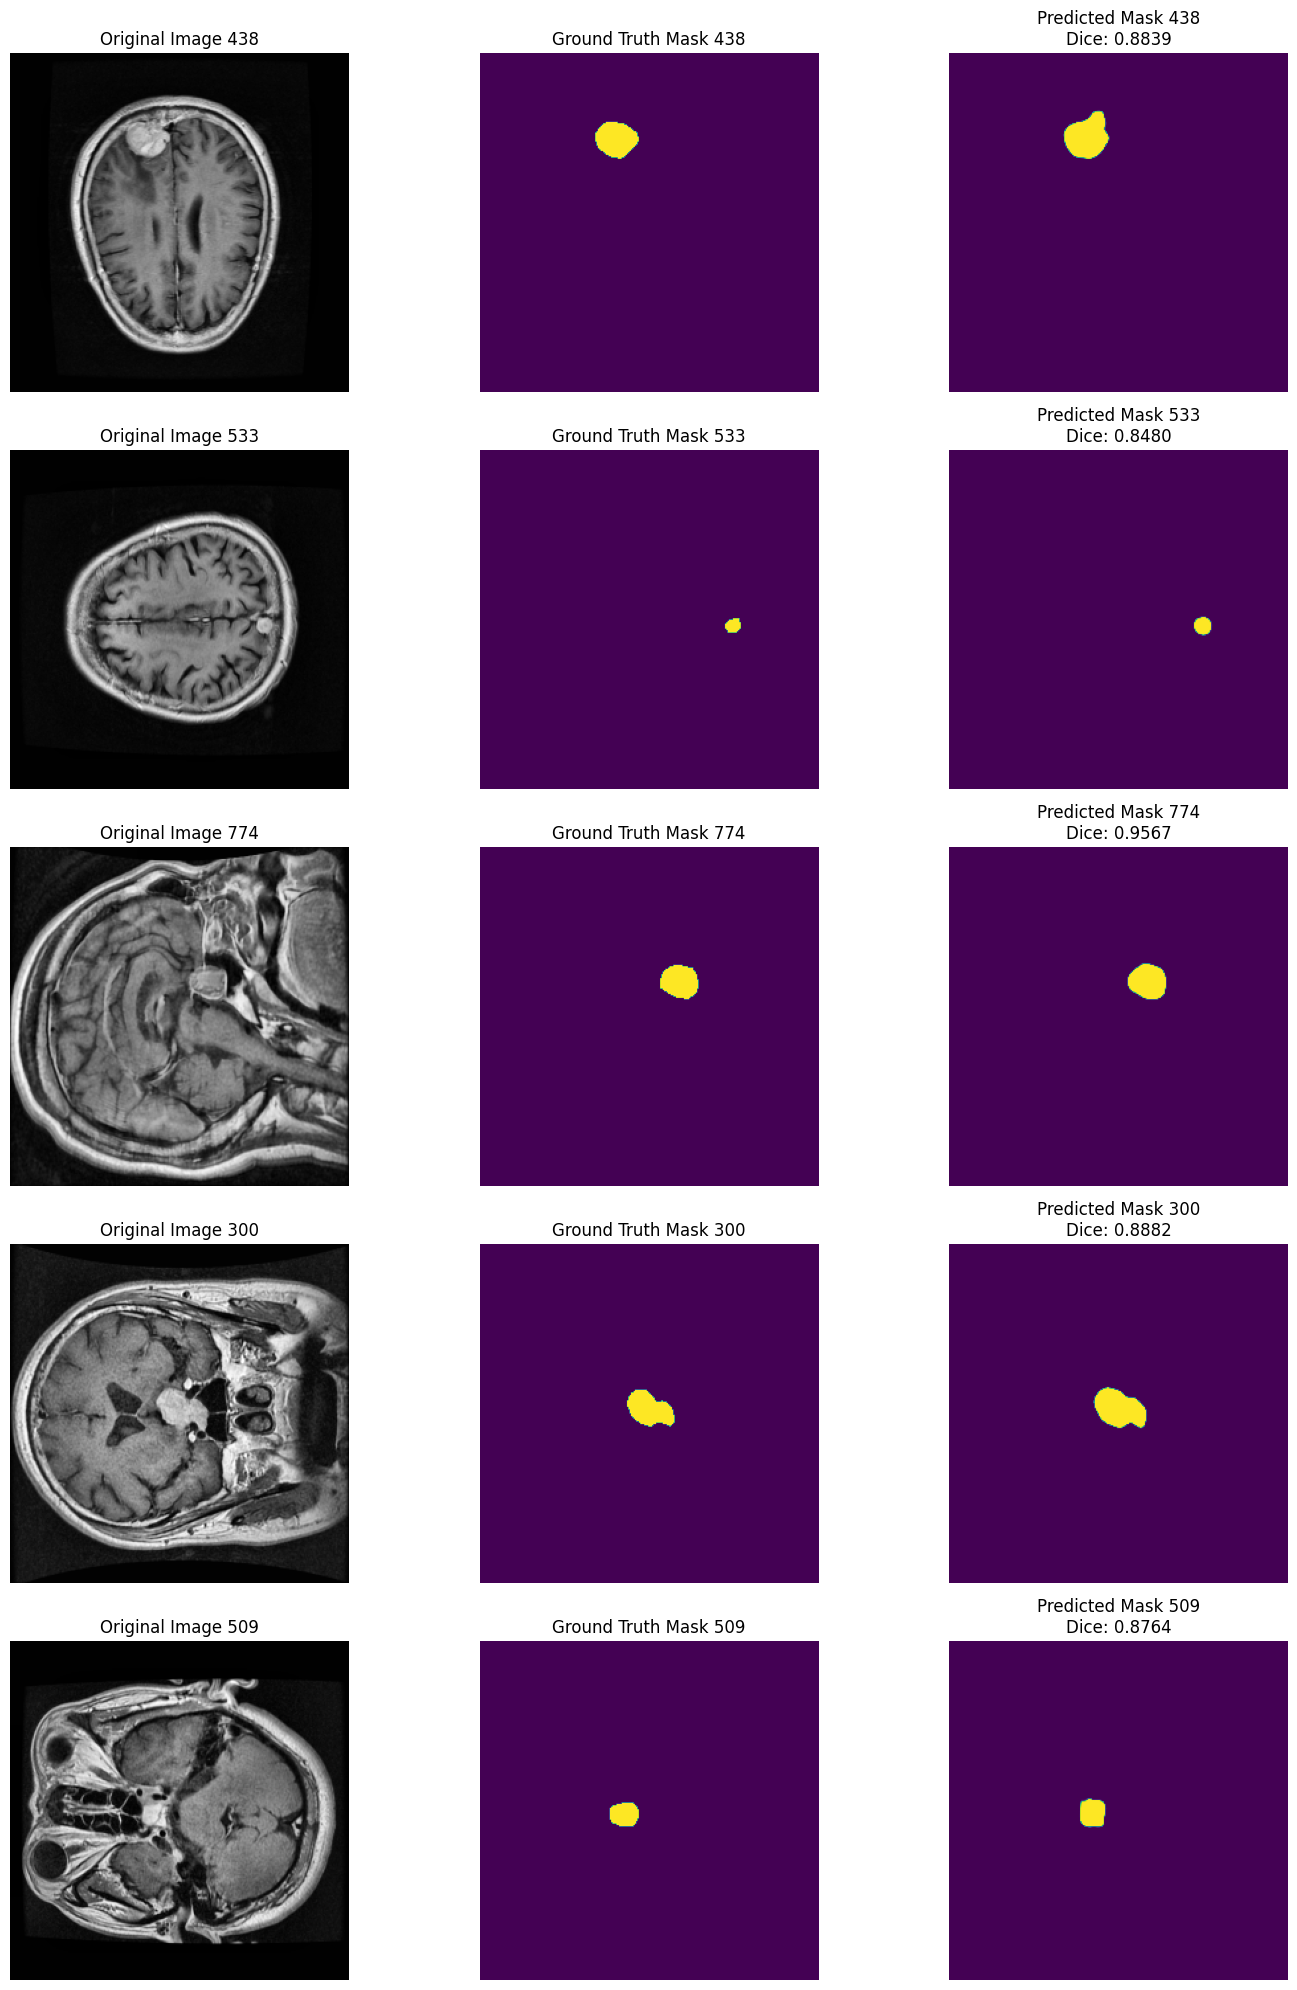

In [16]:

# Function to visualize random predictions
def visualize_random_predictions(X_test, y_test, y_pred, num_samples=5):
    indices = random.sample(range(len(X_test)), num_samples)
    
    plt.figure(figsize=(15, 4*num_samples))
    
    for i, idx in enumerate(indices):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        plt.title(f"Original Image {idx}")
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_test[idx].squeeze(), cmap='viridis')
        plt.title(f"Ground Truth Mask {idx}")
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(y_pred[idx].squeeze(), cmap='viridis')
        plt.title(f"Predicted Mask {idx}\nDice: {dice_coefficient(y_test[idx], y_pred_bin[idx]):.4f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('random_predictions.png')
    plt.show()
# Visualize predictions on random test samples
print("Visualizing random predictions...")
visualize_random_predictions(X_test, y_test, y_pred)


Visualizing overlaid predictions...


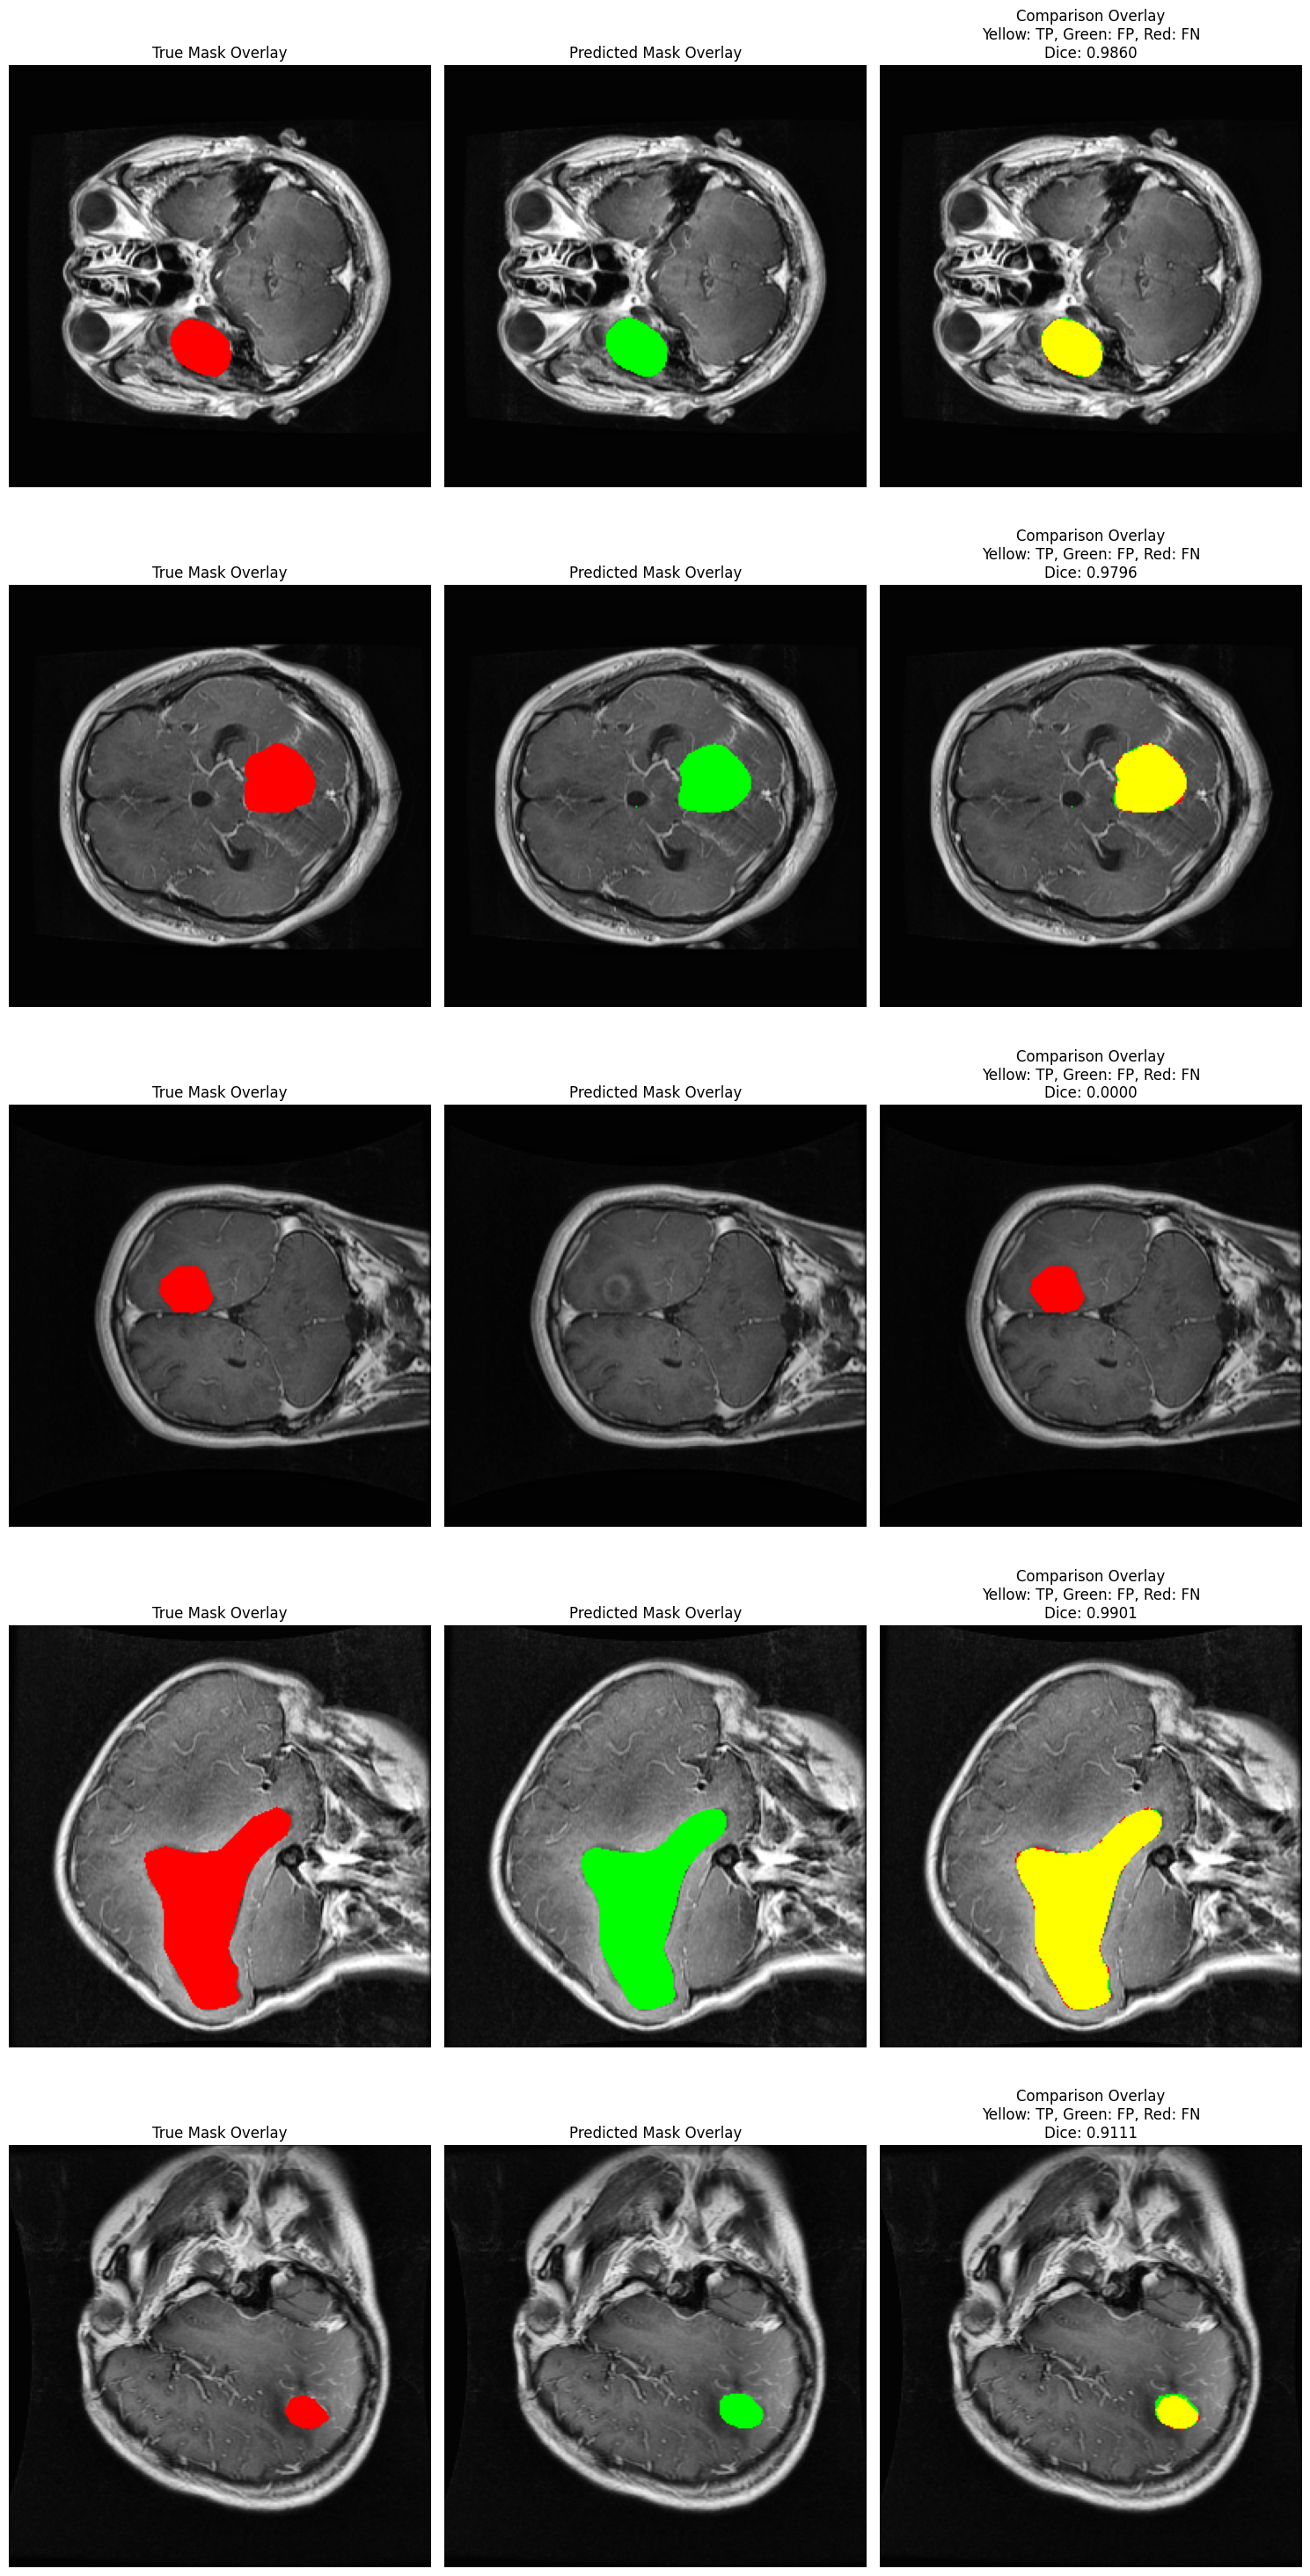

In [17]:
# Function to visualize overlaid predictions
def visualize_overlaid_predictions(X_test, y_test, y_pred, num_samples=5):
    indices = random.sample(range(len(X_test)), num_samples)
    
    plt.figure(figsize=(15, 6*num_samples))
    
    for i, idx in enumerate(indices):
        img = X_test[idx].squeeze()
        true_mask = y_test[idx].squeeze()
        pred_mask = y_pred[idx].squeeze() > 0.5
        
        # Create an RGB version of the grayscale image
        img_rgb = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        
        # Create overlay images
        true_overlay = img_rgb.copy()
        pred_overlay = img_rgb.copy()
        
        # Add red channel for true mask
        true_overlay[true_mask > 0, 0] = 1.0
        true_overlay[true_mask > 0, 1] = 0.0
        true_overlay[true_mask > 0, 2] = 0.0
        
        # Add green channel for predicted mask
        pred_overlay[pred_mask > 0, 0] = 0.0
        pred_overlay[pred_mask > 0, 1] = 1.0
        pred_overlay[pred_mask > 0, 2] = 0.0
        
        # Comparison overlay
        comp_overlay = img_rgb.copy()
        # True positive: yellow
        comp_overlay[(true_mask > 0) & (pred_mask > 0), 0] = 1.0
        comp_overlay[(true_mask > 0) & (pred_mask > 0), 1] = 1.0
        comp_overlay[(true_mask > 0) & (pred_mask > 0), 2] = 0.0
        # False positive: green
        comp_overlay[(true_mask == 0) & (pred_mask > 0), 0] = 0.0
        comp_overlay[(true_mask == 0) & (pred_mask > 0), 1] = 1.0
        comp_overlay[(true_mask == 0) & (pred_mask > 0), 2] = 0.0
        # False negative: red
        comp_overlay[(true_mask > 0) & (pred_mask == 0), 0] = 1.0
        comp_overlay[(true_mask > 0) & (pred_mask == 0), 1] = 0.0
        comp_overlay[(true_mask > 0) & (pred_mask == 0), 2] = 0.0
        
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(true_overlay)
        plt.title(f"True Mask Overlay")
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(pred_overlay)
        plt.title(f"Predicted Mask Overlay")
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(comp_overlay)
        plt.title(f"Comparison Overlay\nYellow: TP, Green: FP, Red: FN\nDice: {dice_coefficient(y_test[idx], y_pred_bin[idx]):.4f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('overlaid_predictions.png')
    plt.show()

# Visualize overlaid predictions
print("Visualizing overlaid predictions...")
visualize_overlaid_predictions(X_test, y_test, y_pred_bin)

Visualizing 3D comparison...


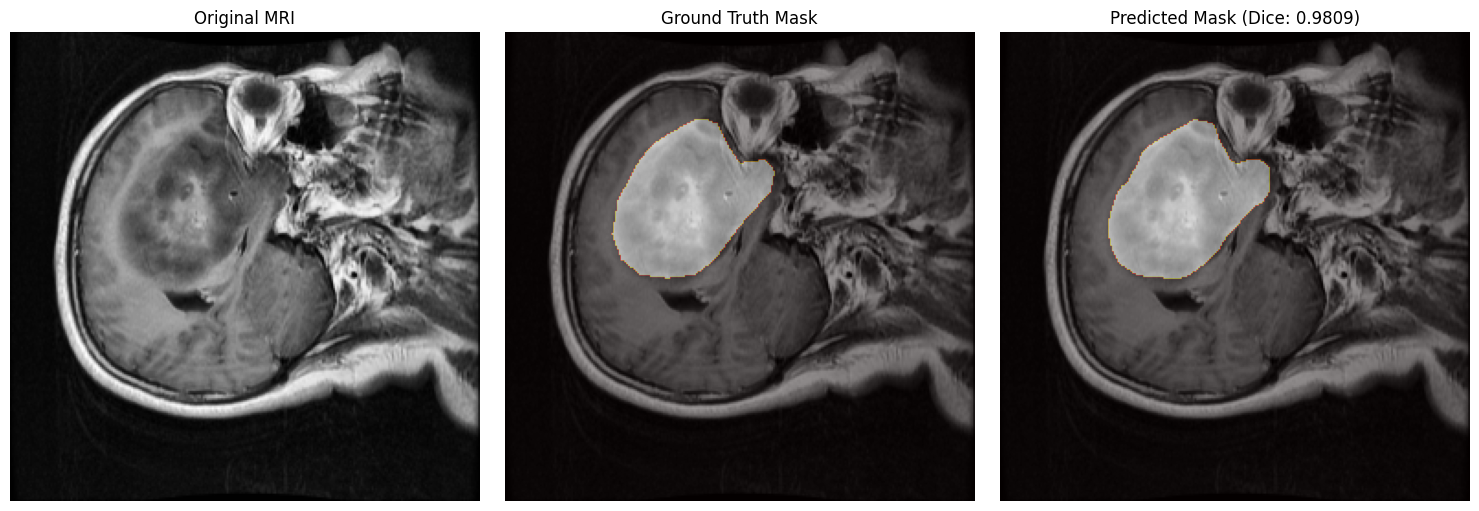

In [18]:
# Function to visualize comparison across image slices
def visualize_3d_comparison(X_test, y_test, y_pred_bin, index=None):
    if index is None:
        # Find an example with a good size tumor
        tumor_sizes = [np.sum(y_test[i]) for i in range(len(y_test))]
        index = np.argsort(tumor_sizes)[-5]  # Get one of the larger tumors
    
    img = X_test[index].squeeze()
    true_mask = y_test[index].squeeze()
    pred_mask = y_pred_bin[index].squeeze()
    
    # Create colormap figures
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original MRI')
    axes[0].axis('off')
    
    # True mask
    axes[1].imshow(img, cmap='gray')
    axes[1].imshow(true_mask, cmap='hot', alpha=0.4)
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')
    
    # Predicted mask
    axes[2].imshow(img, cmap='gray')
    axes[2].imshow(pred_mask, cmap='hot', alpha=0.4)
    dice = dice_coefficient(y_test[index], y_pred_bin[index])
    axes[2].set_title(f'Predicted Mask (Dice: {dice:.4f})')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('3d_visualization.png')
    plt.show()

# Visualize 3D comparison
print("Visualizing 3D comparison...")
visualize_3d_comparison(X_test, y_test, y_pred_bin)